# 05. Inference & MLOps Demo

This notebook demonstrates the complete **Production Pipeline** for the Wearable Stress Biomarker project.
It covers everything from loading the trained artifact to simulating API requests and monitoring for data drift.

**Objectives:**
- **Inference**: Load trained artifact (`StressPredictor`) and predict on validation samples (Instance Normalized).
- **API Simulation**: Verify the REST API contract using `FastAPI` (TestClient) to ensure the model can be served.
- **MLOps Monitoring**: Simulate a simple scenario with "New Users" to detect statistical **Data Drift** likeley requiring model retraining.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastapi.testclient import TestClient

# Setup Environment
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Project Imports
from src.api.app import app
from src.models.predict import StressPredictor
from src.config import load_config, PROJECT_ROOT
from src.visualization.plots import set_plot_style, visualize_inference, visualize_drift
from src.monitoring.drift_report import compute_drift
import src.visualization.plots

# Global Configuration & Paths
MODEL_TYPE = 'deep' # Options: 'deep', 'logistic'
REPORTS_DIR = PROJECT_ROOT / "reports"
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "windows.parquet"

# Initialize Style and Config
set_plot_style()
config = load_config()

print(f"Setup Complete.\nProject Root: {PROJECT_ROOT}\nModel Type: {MODEL_TYPE}")

Setup Complete.
Project Root: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker
Model Type: deep


## 1. Select and Load Model
Choose between `'deep'` (ResNet-1D) or `'logistic'` (Baseline) model types. 
The notebook will automatically find the latest trained artifact in the `reports/` directory.

In [2]:
# 1. Find latest run based on Global Configuration
run_pattern = f"{MODEL_TYPE}_loso_*"
runs = sorted(list(REPORTS_DIR.glob(run_pattern)))

if not runs:
    raise FileNotFoundError(f"No runs found for pattern {run_pattern} in {REPORTS_DIR}. Please run the training pipeline first.")

latest_run = runs[-1]
print(f"Loading Artifact: {latest_run.name}")

# Initialize Predictor
predictor = StressPredictor(latest_run)
print(f"Predictor Ready: {predictor.model_type.upper()}")

Loading Artifact: deep_loso_CHEST_20260118_162043
Predictor Ready: DEEP


## 2. Load Validation Data
We load the full processed dataset to pick random samples. 
In a production scenario, this data would come live from the device.

In [3]:
# 2. Load Validation Data
df = pd.read_parquet(DATA_PATH)

# Filter for Binary Labels only (1=Baseline, 2=Stress)
df = df[df['label'].isin([1, 2])].copy()

# Remap for display
label_map = {1: 'Baseline', 2: 'Stress'}
df['label_str'] = df['label'].map(label_map)

print(f"Data Loaded: {len(df)} windows available.")

Data Loaded: 919 windows available.


## 3. Run Live Inference
Run this cell repeatedly to see different examples!

--- CASE 1: STRESS SAMPLE ---


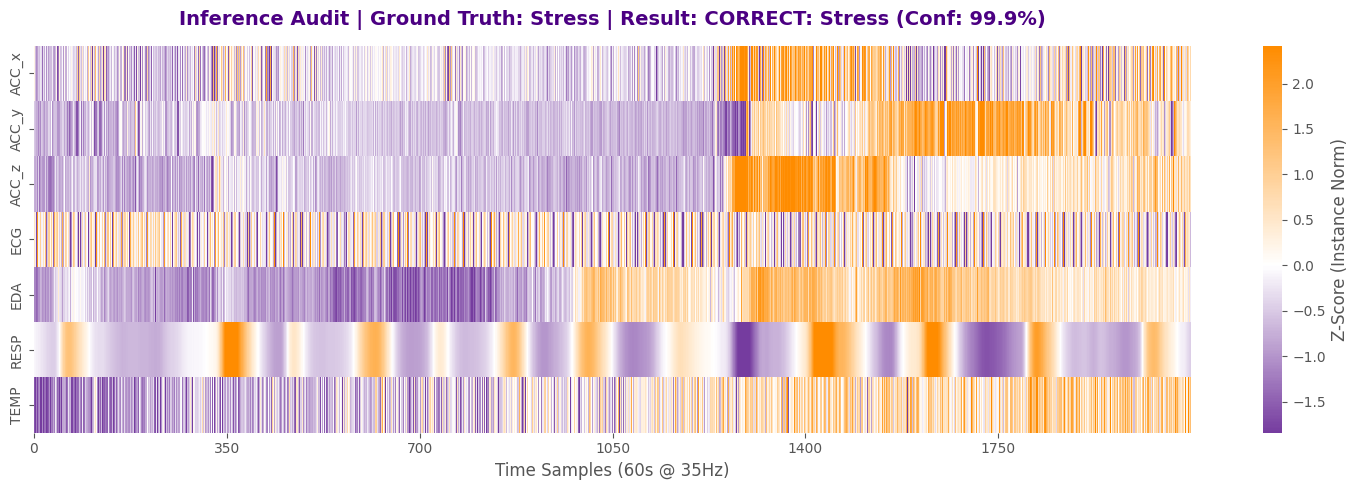

--- CASE 2: BASELINE SAMPLE ---


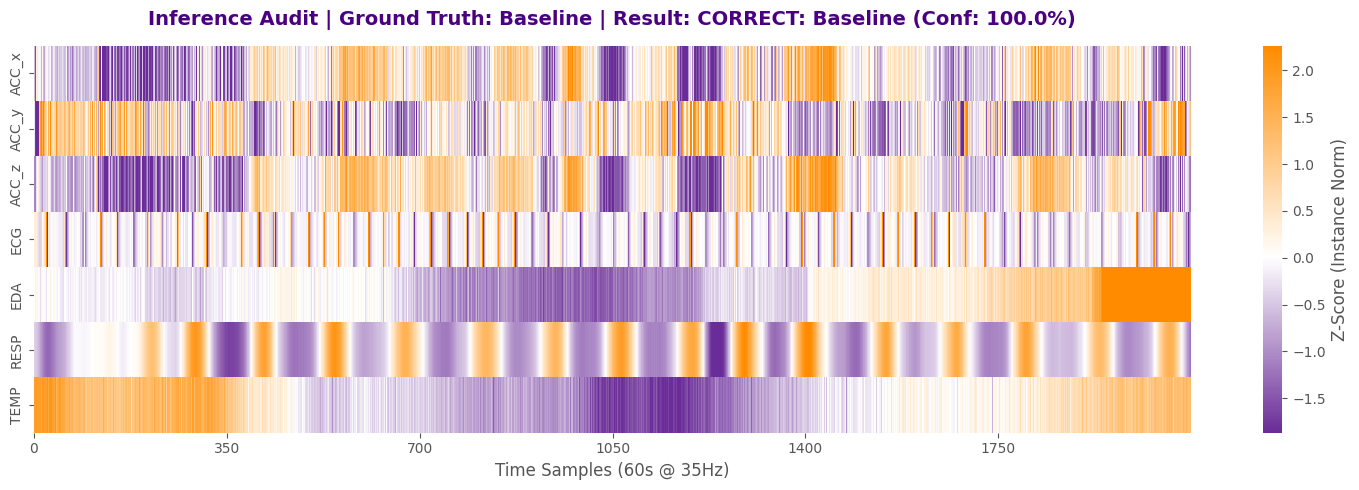

In [4]:
# 3. Sample 1 Random Stress and 1 Random Baseline Window
stress_sample = df[df['label'] == 2].sample(1).iloc[0]
baseline_sample = df[df['label'] == 1].sample(1).iloc[0]

print("--- CASE 1: STRESS SAMPLE ---")
_ = visualize_inference(stress_sample, predictor)
plt.show()

print("--- CASE 2: BASELINE SAMPLE ---")
_ = visualize_inference(baseline_sample, predictor)
plt.show()

## 4. API Endpoint Verification
Demonstrates how to use the FastAPI endpoint directly from Python using `TestClient`.
This simulates a REST API call as if the server were running.

In [5]:
# 4. Initialize Test Client
with TestClient(app) as client:
    
    # Prepare Payload from the loaded 'stress_sample'
    payload = {
        "ACC_x": stress_sample['ACC_x'].tolist(),
        "ACC_y": stress_sample['ACC_y'].tolist(),
        "ACC_z": stress_sample['ACC_z'].tolist(),
        "ECG": stress_sample['ECG'].tolist(),
        "EDA": stress_sample['EDA'].tolist(),
        "RESP": stress_sample['RESP'].tolist(),
        "TEMP": stress_sample['TEMP'].tolist()
    }

    # Send Request
    print("Sending request to /predict (stress sample)...")
    response = client.post("/predict", json=payload)

    # Parse Response
    if response.status_code == 200:
        res_json = response.json()
        print("\n--- API Response ---")
        print(f"Status: {res_json['status']}")
        print(f"Prediction: {res_json['prediction']}")
        print(f"Confidence: {res_json['confidence']:.4f}")
        print(f"Probabilities: {res_json['probabilities']}")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

2026-01-18 17:55:30,536 - src.api.app - INFO - Loading Model Artifact: deep_loso_CHEST_20260118_162043
2026-01-18 17:55:30,557 - src.api.app - INFO - StressPredictor initialized successfully (deep).
Sending request to /predict (stress sample)...

--- API Response ---
Status: Success
Prediction: Stress
Confidence: 0.9992
Probabilities: {'Baseline': 0.0008113725343719125, 'Stress': 0.9991886019706726}


## 5. Drift Monitoring (Data Drift)

In MLOps, it is crucial to monitor if the input data distribution $P(X)$ changes over time ("Data Drift"). Unlike **Concept Drift** (where the relationship $P(Y|X)$ changes), **Data Drift** often occurs when the model encounters new populations or environments.

Here, we simulate a production scenario:
*   **Reference Batch**: Data from Training Subjects (seen by model).
*   **Current Batch**: Data from "New Users" (unseen subjects).

We use the **Kolmogorov-Smirnov (KS) Test** to verify if the physiological feature distributions differ significantly between these groups. Significant drift (p < 0.05) triggers an alert for investigation.

Reference Group: ['S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8']
Current Group: ['S9' 'S10' 'S11' 'S13' 'S14' 'S15' 'S16' 'S17']

Calculating Drift Report...
2026-01-18 17:55:30,658 - src.monitoring.drift_report - INFO - Extracting monitoring features...
--- Drift Report: 10/15 features showed significant distributional shift (p<0.05). ---


,Feature,P-Value,Drift Detected,Ref Mean,Cur Mean
3,ACC_y_mean,1.070076e-12,True,-0.078299,0.012088
9,EDA_mean,6.422180e-10,True,6.334828,3.336774
12,RESP_std,2.749465e-08,True,2.734605,3.653908
10,EDA_std,8.001544e-07,True,0.098016,0.023593
6,ACC_z_std,6.281177e-05,True,0.029412,0.055612
13,TEMP_mean,1.293506e-03,True,33.477009,34.042027
7,ECG_mean,1.293506e-03,True,0.001155,0.001023
14,TEMP_std,3.729492e-03,True,0.189526,0.024796
4,ACC_y_std,2.405580e-02,True,0.020931,0.027056
2,ACC_x_std,3.638429e-02,True,0.017771,0.019046


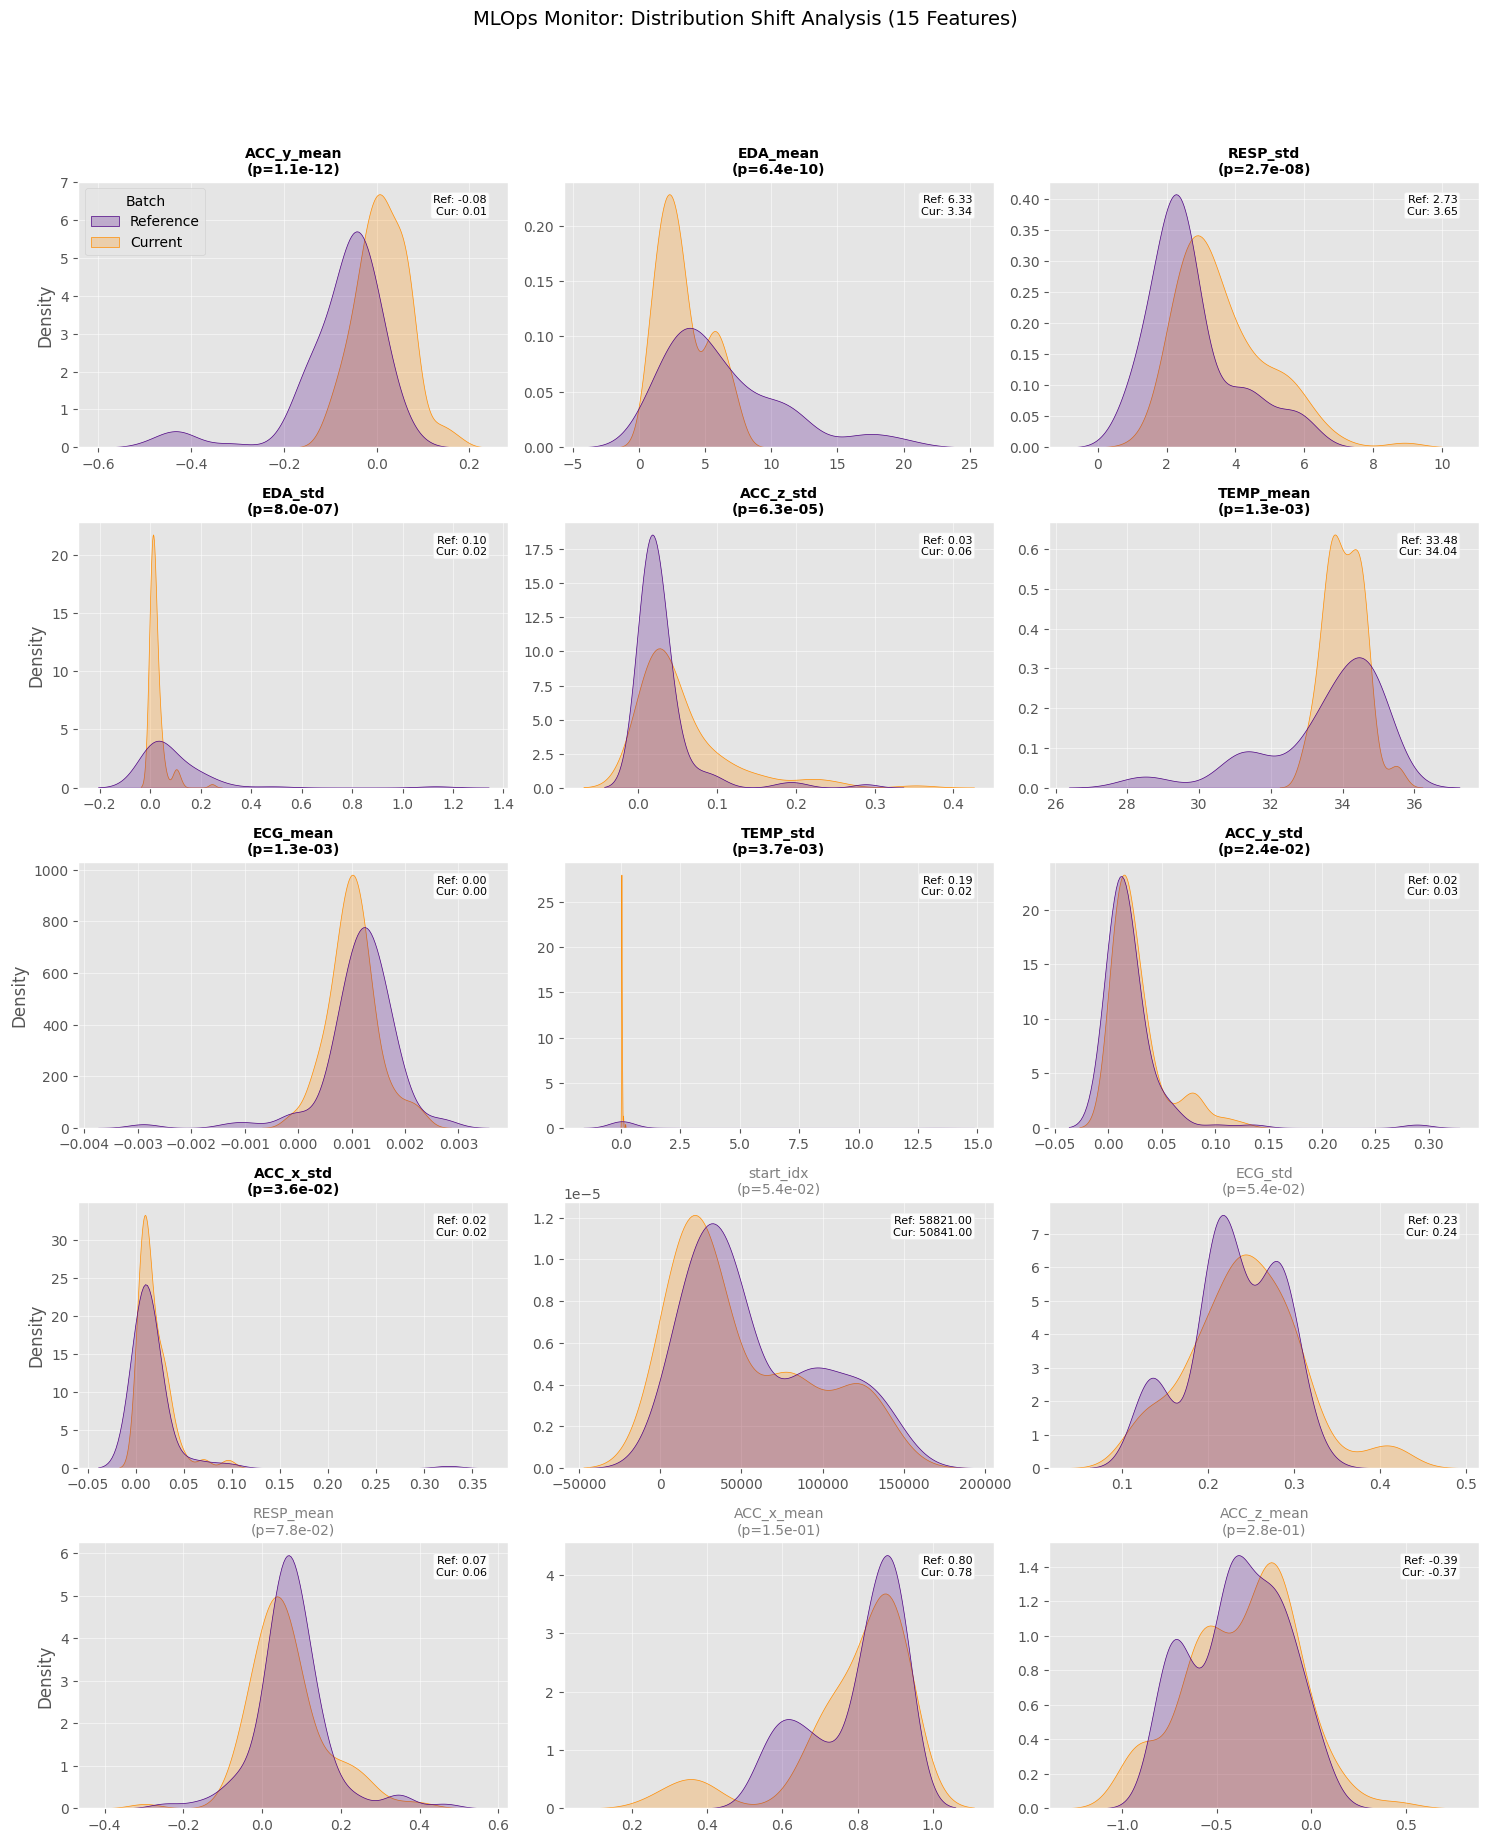

In [6]:
# 5. Simulate Batches
subjects = df['subject_id'].unique()
ref_subjects = subjects[:len(subjects)//2]
curr_subjects = subjects[len(subjects)//2:]

print(f"Reference Group: {ref_subjects}")
print(f"Current Group: {curr_subjects}")

# Sample windows from each group
df_ref = df[df['subject_id'].isin(ref_subjects)].sample(100, replace=True, random_state=42)
df_curr = df[df['subject_id'].isin(curr_subjects)].sample(100, replace=True, random_state=42)

# Run Drift Analysis
print("\nCalculating Drift Report...")
drift_report = compute_drift(df_ref, df_curr)

# Visualize Results (Table + 3x5 Mosaic of All Features)
drift_df = visualize_drift(drift_report, df_ref, df_curr)
display(drift_df)